In [300]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [301]:
def crop_white_space(image):
    # Crop out the leading and trailing white space from all sides (left, right, top, bottom)
    
    # Find non-white rows (rows with any non-white pixels)
    non_white_rows = np.where(image.min(axis=1) < 255)[0]
    top = non_white_rows.min()  # Top row with non-white pixels
    bottom = non_white_rows.max()  # Bottom row with non-white pixels
    
    # Find non-white columns (columns with any non-white pixels)
    non_white_cols = np.where(image.min(axis=0) < 255)[0]
    left = non_white_cols.min()  # Leftmost column with non-white pixels
    right = non_white_cols.max()  # Rightmost column with non-white pixels
    
    # Crop the image to include only the relevant part of the barcode
    cropped_image = image[top:bottom+1, left:right+1]
    
    return cropped_image


def read_barcode(image):
    cropped = crop_white_space(image)
    _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Get the average of each column in your image
    mean = binary.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))
    i = 0 
    for pixel in pixels:
        if pixel != "1":
            i += 1
        else:
            break
    i = (i * (-1)) 
    print(i)
    if i != 0:
        rows, cols = cropped.shape[:2]
        translation_matrix = np.float32([[1, 0, (i)], [0, 1, 0]])  
        cropped = cv2.warpAffine(cropped, translation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(0))
        _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = binary.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))
    i = 0 
    for pixel in pixels:
        if pixel != "1":
            i += 1
        else:
            break
    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break
    print(narrow_bar_size)
    # print("Narrow Bar Size:", narrow_bar_size)  # Print the narrow bar size
    
    # Set a tolerance value (tolerance allows slightly wider bars to be considered as narrow)
    tolerance = 1  # You can adjust this value based on your barcode's characteristics
    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass  # Handle IndexError gracefully
        pixel_index += 1
        
        # print("--------------------")
        # print("Current Count:", count)  # Print the count of the current pixel
        # print("--------------------")

        # If the width is slightly bigger than narrow bar size but smaller than wide bar size, treat it as narrow
        if count <= narrow_bar_size + tolerance:
            current_digit_widths += NARROW
        else:
            current_digit_widths += WIDE

        # print("Current Digit Widths:", current_digit_widths)  # Print each width detected

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            # print("Decoded Digit:", code11_widths[current_digit_widths])  # Print decoded digit
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

        if pixel_index >= len(pixels):
            # print("Warning: Pixel index exceeded bounds.")
            break

    print(digits)  # Print the final decoded digits list


In [302]:
# def remove_finger(image):
#     # Step 1: Detect the finger (skin color) and mask it out
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     lower_skin = np.array([0, 20, 70], dtype=np.uint8) 
#     upper_skin = np.array([20, 255, 255], dtype=np.uint8)
#     skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    
#     # Threshold the skin mask to remove the finger region
#     _, binary_skin_mask = cv2.threshold(skin_mask, 127, 255, cv2.THRESH_BINARY_INV)
    
#     # Mask the image to remove the finger region
#     masked_image = cv2.bitwise_and(image, image, mask=binary_skin_mask)
    
#     # Convert the masked image to grayscale
#     gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

#     return gray_image


def remove_finger(image):
    # Step 1: Detect the finger (skin color) and mask it out
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8) 
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Create an inverted mask where skin is white (255) and non-skin is black (0)
    binary_skin_mask = skin_mask  # Skin regions are already white (255)
    
    # Create a blank white image
    white_image = np.ones_like(image) * 255  # All pixels set to 255 (white)
    
    # Replace skin regions with white in the original image
    masked_image = cv2.bitwise_and(white_image, white_image, mask=binary_skin_mask)  # White for skin
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_skin_mask))  # Original for non-skin
    result = cv2.add(background, masked_image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    return gray_image

In [303]:
def remove_wave_noise(image):
    # Step 2: Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Step 2.1: Analyze intensity histogram to detect noise
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_variance = np.var(hist)  # Variance of histogram values
    
    # Perform frequency domain filtering only if histogram variance is high
    if hist_variance > 5000:  # Adjust this threshold based on test cases
        # Apply Discrete Fourier Transform (DFT)
        dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        # Compute the magnitude spectrum
        magnitude = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

        # Create a notch filter to suppress noise frequencies
        rows, cols = gray.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols, 2), np.uint8)
        mask[crow-30:crow+30, ccol-30:ccol+30] = 0  # Suppress center frequencies

        # Apply the mask and perform inverse Fourier Transform
        fshift = dft_shift * mask
        f_ishift = np.fft.ifftshift(fshift)
        filtered = cv2.idft(f_ishift)
        filtered = cv2.magnitude(filtered[:, :, 0], filtered[:, :, 1])

        # Normalize the result back to 8-bit range
        filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return filtered
    else:
        return gray  # If no wave noise, use the original image

In [304]:
def adjust_orientation(image, horizontal_threshold=5):
    # Detect edges using Canny edge detector
    edges = cv2.Canny(image, 50, 150)
    
    # Perform Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)
    
    if lines is not None:
        # Calculate the average angle of the detected lines
        angles = []
        for rho, theta in lines[:, 0]:
            angles.append(theta)
        
        # Convert from radians to degrees
        avg_angle = np.mean(angles) * 180 / np.pi
        
        # Determine the angle to rotate
        if avg_angle > 90:
            angle_to_rotate = avg_angle - 180
        else:
            angle_to_rotate = avg_angle
        
        # Check if the angle is within the horizontal threshold
        if abs(angle_to_rotate) < horizontal_threshold:
            # If the angle is already nearly horizontal, return the original image
            return image
        
        # Otherwise, rotate the image to make it horizontal
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_to_rotate, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        return rotated
    else:
        # If no lines are detected, return the original image
        return image

In [305]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_frequency_response(image):
    # Convert to grayscale if the image is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the DFT of the image
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency component to the center

    # Calculate the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    magnitude_spectrum = 20 * np.log(np.maximum(magnitude_spectrum, 1))  # Log scale for better visualization

    # Display the original image and its magnitude spectrum
    plt.figure(figsize=(20, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    # Frequency response (magnitude spectrum)
    plt.subplot(1, 2, 2)
    plt.title("Frequency Response (Magnitude Spectrum)")
    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.axis("off")

    plt.show()


In [306]:
def preprocess_barcode(image):
    wave_noise = False
    
    # Remove the finger region from the image
    finger_free_image = remove_finger(image)
    
    # Preprocess the image to enhance the barcode region
    denoised = cv2.medianBlur(cv2.blur(finger_free_image, (1, 9)), 3)

    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    dilated = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)

    if len(np.unique(dilated)) != 1:
        print ("Periodic noise detected")
        wave_noise = True
        # Adaptive Thresholding instead of Otsu's method
        adaptive_image = cv2.adaptiveThreshold(
            finger_free_image, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # or cv2.ADAPTIVE_THRESH_MEAN_C
            cv2.THRESH_BINARY, 
            11,  # block size (must be an odd number)
            2    # constant subtracted from the mean or weighted mean
        )
        denoised = cv2.medianBlur(cv2.blur(adaptive_image, (1, 9)), 3)
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        

    # # Adjust Orientation
    # oriented_image = adjust_orientation(binary)
    
    # Detect edges using the Sobel filter
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)
    
    # Close gaps in the barcode lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)
    
    # Remove small artifacts
    kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_clean)
    
    # Find contours and crop the barcode region
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get rotated bounding box
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        rows,cols = box.shape
        # Ensure width is always greater than height
        width = int(max(rect[1]))
        height = int(min(rect[1]))
        print(box)
        # isOriented = False
        # if box[0, 1] != box[1,1] or box[2,1] != box[3,1]:
        #     isOriented = True          
        # Correct perspective based on the box points
        src_pts = box.astype("float32")
        dst_pts = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        cropped = cv2.warpPerspective(binary, M, (width, height))
        if wave_noise:
            cropped = cv2.medianBlur(cv2.blur(cropped, (1, 50)), 3)
        else:
            cropped = cv2.medianBlur(cv2.blur(cropped, (1, 300)), 3)
            # vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 185))
            # cropped = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, vertical_kernel)
    else:
        cropped = binary
        
    # Add shift operation to move cropped image 10 pixels to the left
    # print(isOriented)
    # if isOriented:
    #     rows, cols = cropped.shape[:2]
    #     translation_matrix = np.float32([[1, 0, -4], [0, 1, 0]])  
    #     cropped = cv2.warpAffine(cropped, translation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(0))
    if wave_noise:
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 1))
        cropped = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, vertical_kernel)
    return binary, closed, cropped

[[200 172]
 [601 172]
 [601 373]
 [200 373]]


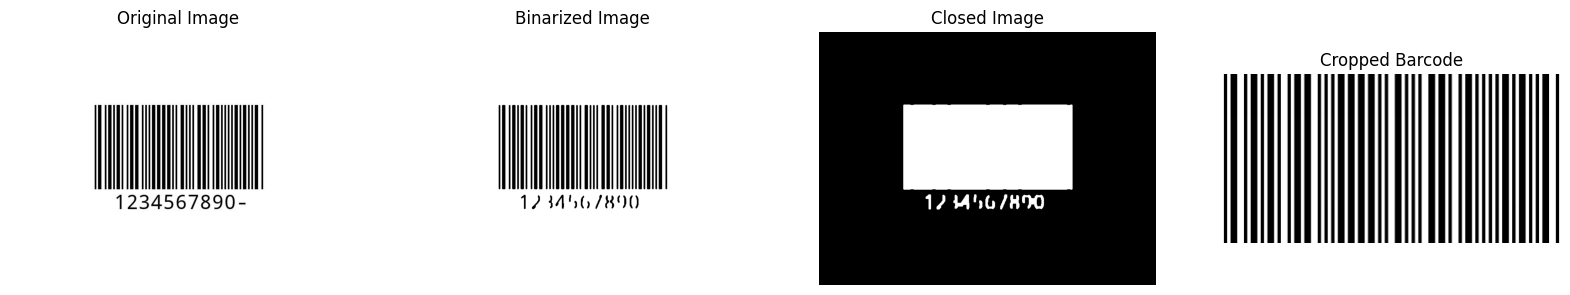

0
4
['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


In [307]:
image_path = "Test Cases\\01 - lol easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[ 39  39]
 [440  39]
 [440 240]
 [ 39 240]]


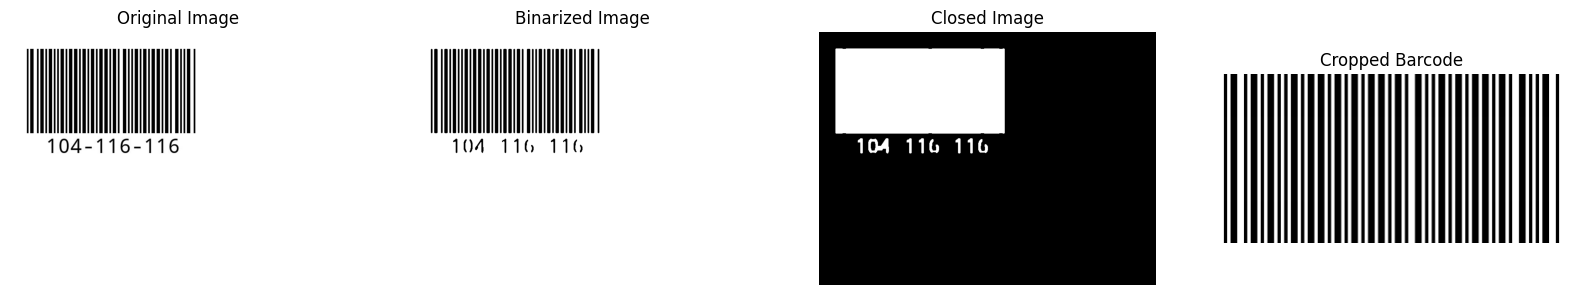

0
4
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


In [308]:
image_path = "Test Cases\\02 - still easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show() 

read_barcode(cropped)

[[ 85 243]
 [486 243]
 [486 444]
 [ 85 444]]


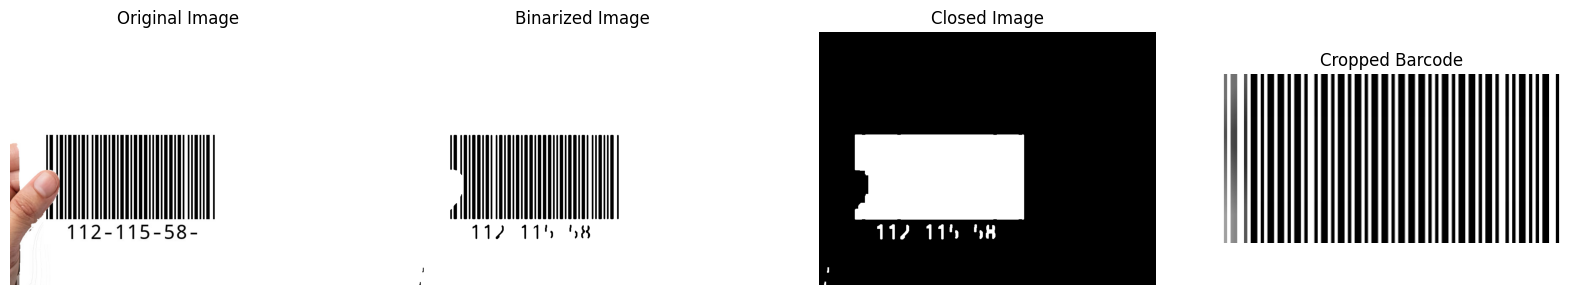

0
4
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']


In [309]:
image_path = "Test Cases\\03 - eda ya3am ew3a soba3ak mathazarsh.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[ 91 240]
 [488 240]
 [488 443]
 [ 91 443]]


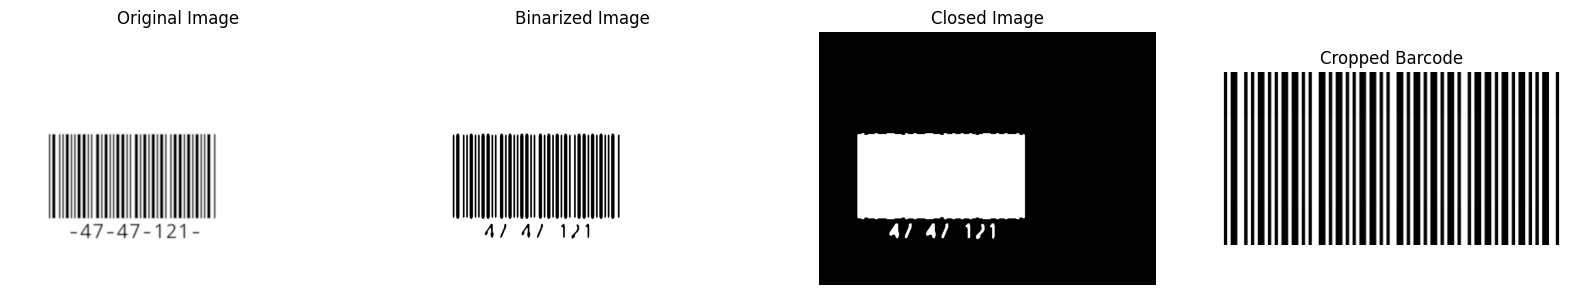

0
4
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']


In [310]:
image_path = "Test Cases\\04 - fen el nadara.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[ 55  97]
 [460  97]
 [460 298]
 [ 55 298]]


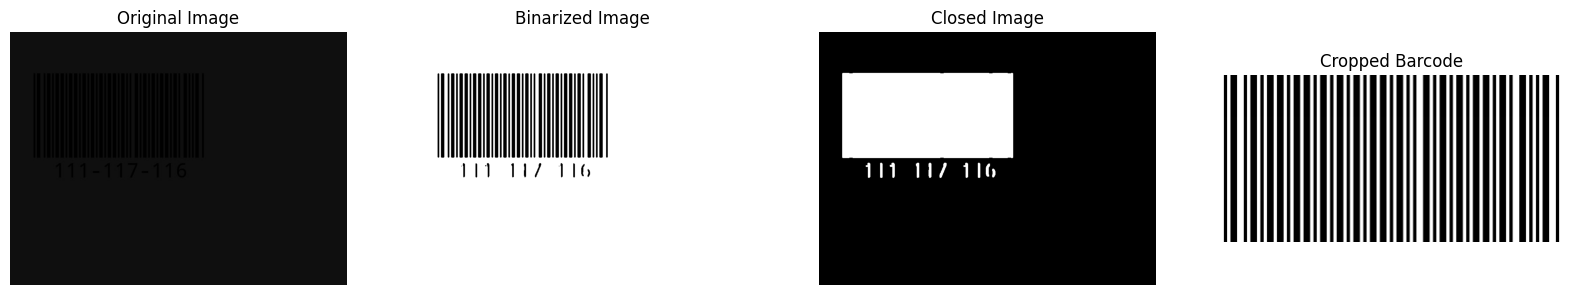

0
4
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


In [311]:
image_path = "Test Cases\\05 - meen taffa el nour!!!.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[338 301]
 [731 301]
 [731 504]
 [338 504]]


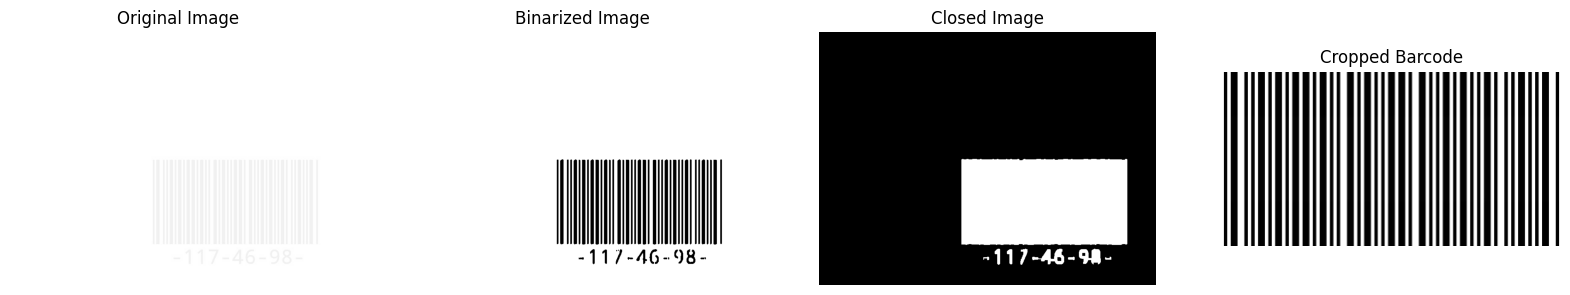

0
4
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


In [312]:
image_path = "Test Cases\\06 - meen fata7 el nour 333eenaaayy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[205 170]
 [595 170]
 [595 374]
 [205 374]]


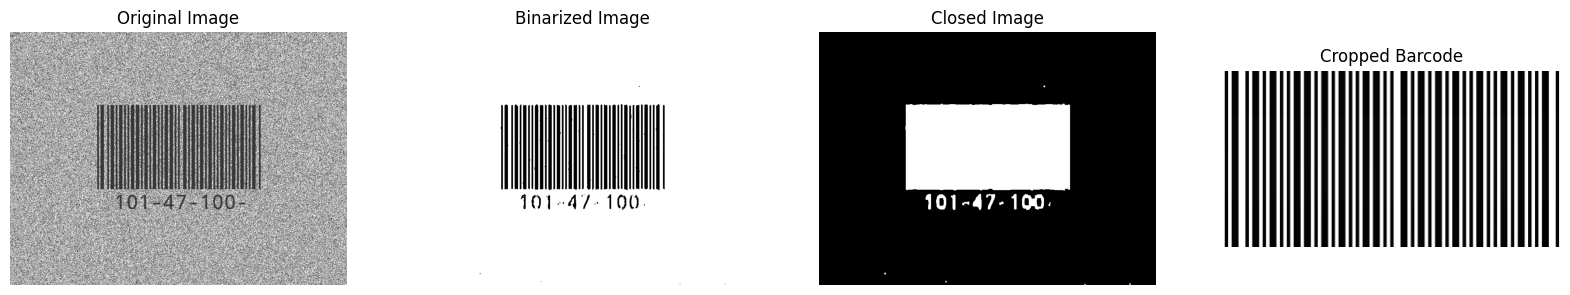

-1
4
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']


In [313]:
image_path = "Test Cases\\07 - mal7 w felfel.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[229 332]
 [626 332]
 [626 535]
 [229 535]]


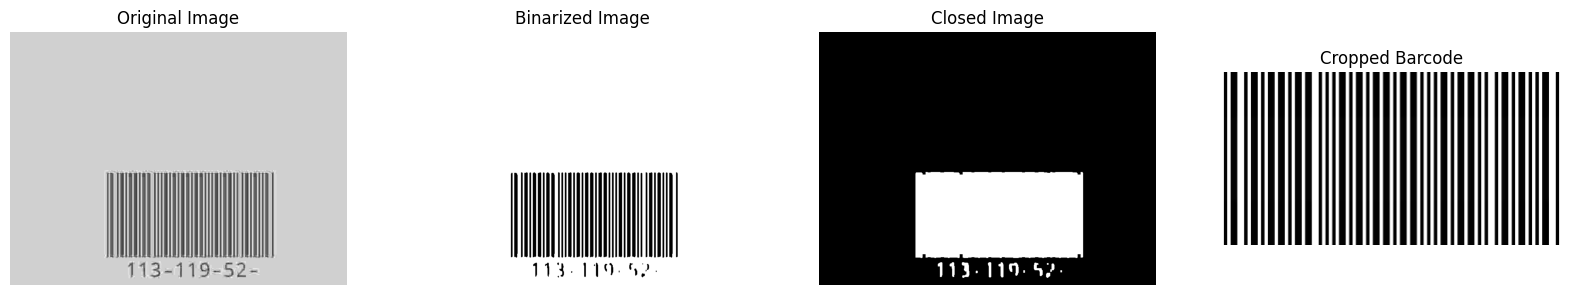

0
4
['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


In [314]:
image_path = "Test Cases\\08 - compresso espresso.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[-27 164]
 [323 -22]
 [420 159]
 [ 69 346]]


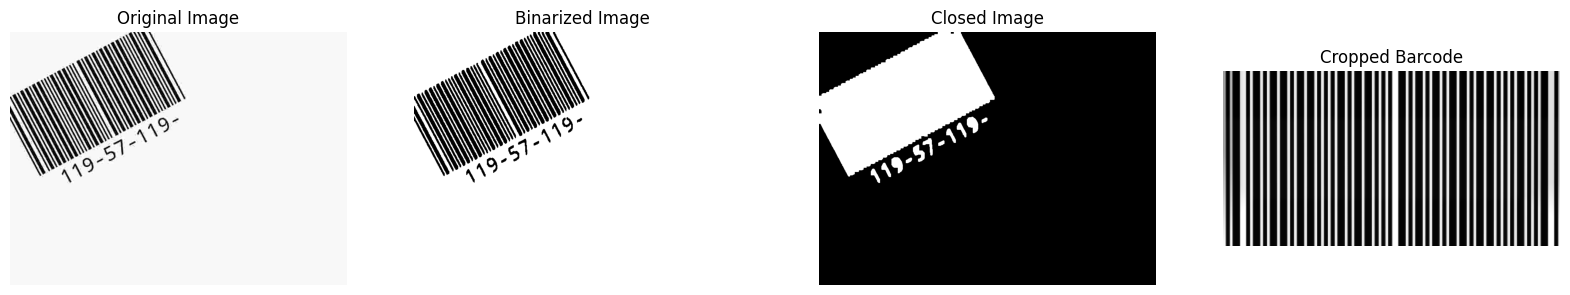

-3
5
['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


In [315]:
image_path = "Test Cases\\09 - e3del el soora ya3ammm.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

[[208 171]
 [593 171]
 [593 374]
 [208 374]]


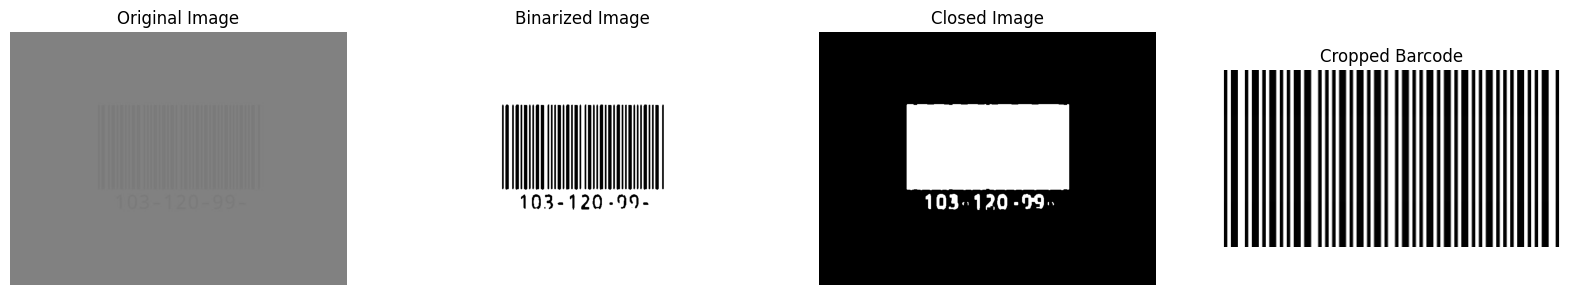

0
4
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


In [316]:
image_path = "Test Cases\\10 - wen el kontraastttt.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

Periodic noise detected
[[ 60 360]
 [477 236]
 [535 432]
 [118 556]]


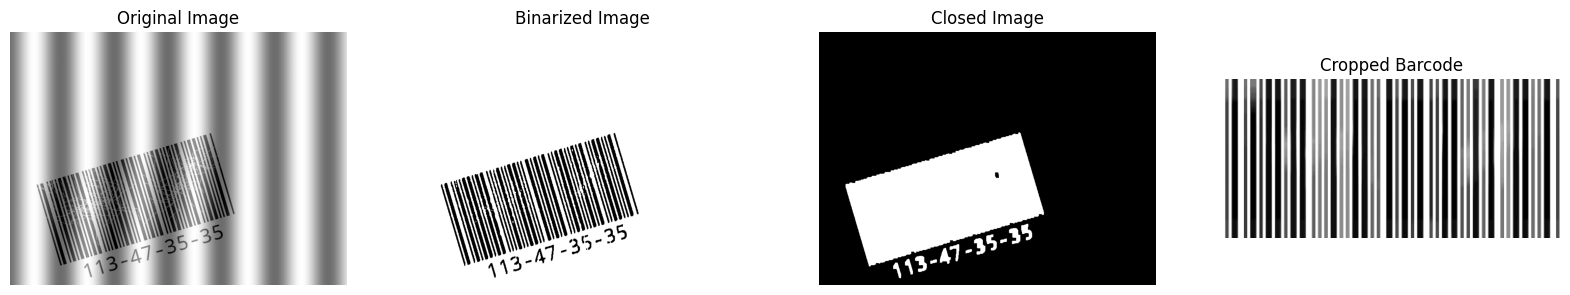

-1
4
['Stop/Start', '1', '1', '3']


In [317]:
image_path = "Test Cases\\11 - bayza 5ales di bsara7a.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Binarized Image 
plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binarized Image")
plt.axis("off")

# Closed Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(closed, cmap='gray')
plt.title("Closed Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

read_barcode(cropped)

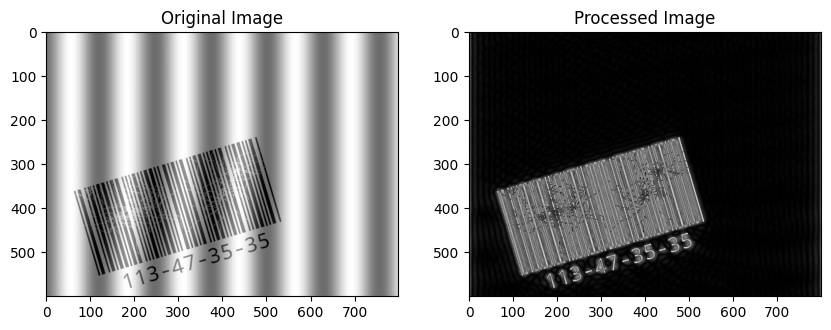

In [318]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_wave_noise(image):
    # Step 1: Convert the image to grayscale (if it's a color image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Perform Fourier Transform to get the frequency domain
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center

    # Step 3: Create a mask to filter out the wave noise
    rows, cols = gray_image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image

    # Example: A simple low-pass filter, you can modify the size to suit your needs
    mask = np.ones((rows, cols), np.uint8)
    r = 30  # Radius of the filter
    center = [crow, ccol]  # Center of the image

    # Mask with a circular region set to 0 (this can be adjusted to remove the noise)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= r * r
    mask[mask_area] = 0

    # Step 4: Apply the mask to the shifted Fourier coefficients
    fshift = fshift * mask

    # Step 5: Inverse FFT to bring the image back to the spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Step 6: Normalize the image (optional)
    img_back = np.uint8(np.interp(img_back, (img_back.min(), img_back.max()), (0, 255)))

    return img_back

# Load the image
image = cv2.imread('Test Cases/11 - bayza 5ales di bsara7a.jpg')  # Replace with your image file path

# Remove wave noise
cleaned_image = remove_wave_noise(image)

# Display the original and cleaned images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Processed Image")
plt.imshow(cleaned_image, cmap='gray')

plt.show()


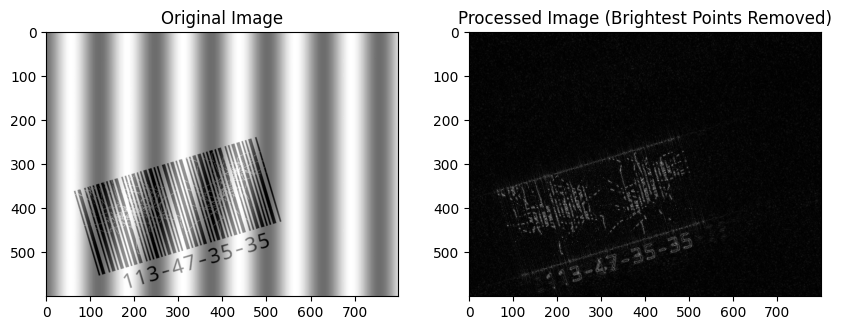

In [319]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_brightest_points(image, threshold_factor=5):
    """
    Remove the brightest points in the frequency domain that have high magnitude
    impact on the image (by zeroing out high-frequency components).
    
    :param image: The input grayscale image
    :param threshold: The magnitude threshold to identify high-impact points.
    :return: The image after removing the brightest points in the frequency domain.
    """
    # Step 1: Perform Fourier Transform on the grayscale image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center

    # Step 2: Calculate the magnitude of the frequency components
    magnitude = np.abs(fshift)

    # Step 3: Identify the brightest points by applying the threshold
    # Mask out high-magnitude points (those greater than the threshold)
    median_magnitude = np.median(magnitude)
    threshold = median_magnitude * threshold_factor
    fshift[magnitude > threshold] = 0  # Remove bright points (set to zero)

    # Step 4: Inverse FFT to bring the image back to the spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Step 5: Normalize the processed image to uint8
    img_back = np.uint8(np.interp(img_back, (img_back.min(), img_back.max()), (0, 255)))

    return img_back

# Load the image (in grayscale)
image = cv2.imread('Test Cases\\11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Remove the brightest points in the frequency domain
cleaned_image = remove_brightest_points(image, threshold_factor=5)

# Display the original and cleaned images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Processed Image (Brightest Points Removed)")
plt.imshow(cleaned_image, cmap='gray')

plt.show()


Mean magnitude: 5693.33049768964
Highest frequency point at index: (np.int64(300), np.int64(400)), magnitude: 81761108.0


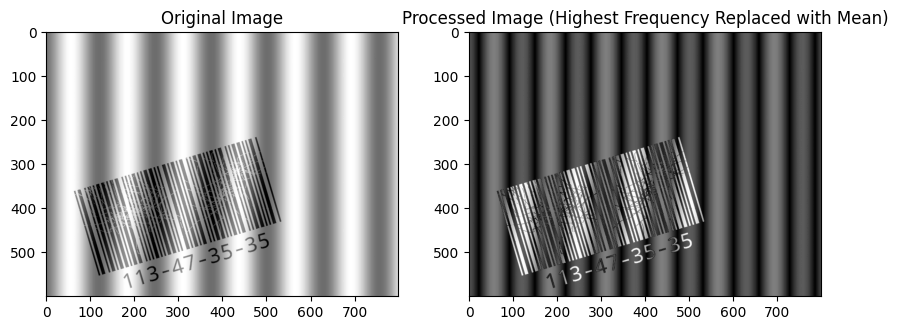

In [320]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def replace_highest_with_mean(image):
    """
    Replace the highest frequency point in the Fourier domain with the mean of all frequencies.
    
    :param image: The input grayscale image
    :return: The image after replacing the highest frequency point with the mean in the frequency domain.
    """
    # Step 1: Perform Fourier Transform on the grayscale image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center

    # Step 2: Calculate the magnitude of the frequency components
    magnitude = np.abs(fshift)

    # Step 3: Calculate the mean of the frequency magnitudes
    mean_magnitude = np.mean(magnitude)
    print(f"Mean magnitude: {mean_magnitude}")

    # Step 4: Identify the highest frequency point (the largest magnitude)
    max_idx = np.unravel_index(np.argmax(magnitude), magnitude.shape)  # Find the index of the highest value
    print(f"Highest frequency point at index: {max_idx}, magnitude: {magnitude[max_idx]}")

    # Step 5: Replace the highest frequency point with the mean magnitude
    fshift[max_idx] = mean_magnitude + 1j * 0  # Set the real part to the mean and imaginary part to 0

    # Step 6: Inverse FFT to bring the image back to the spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # # Step 7: Normalize the processed image to uint8
    img_back = np.uint8(np.interp(img_back, (img_back.min(), img_back.max()), (0, 255)))

    return img_back

# Load the image (in grayscale)
image = cv2.imread('Test Cases\\11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Replace the highest frequency point with the mean magnitude
cleaned_image = replace_highest_with_mean(image)

# Display the original and cleaned images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Processed Image (Highest Frequency Replaced with Mean)")
plt.imshow(cleaned_image, cmap='gray')

plt.show()


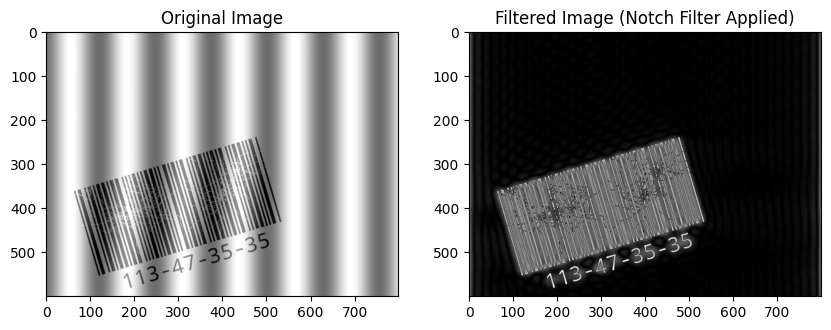

In [321]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def notch_filter(image, notch_radius=10):
    """
    Apply a notch filter to remove specific frequencies in the Fourier domain.
    
    :param image: The input grayscale image
    :param notch_center: The (x, y) coordinate in the frequency domain to center the notch
    :param notch_radius: The radius around the notch_center to remove
    :return: The image after applying the notch filter.
    """
    # Step 1: Perform Fourier Transform on the image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center

    # Step 2: Create a notch filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image
    
    # Create a mask of the same size as the image
    mask = np.ones((rows, cols), dtype=np.uint8)
    
    # Define the notch center and radius to zero-out the specified frequencies
    y, x = np.ogrid[:rows, :cols]
    distance = (x - ccol) ** 2 + (y - crow) ** 2  # Calculate distance from the center
    
    # Set the region around the notch center to 0
    mask[distance <= notch_radius**2] = 0

    # Step 3: Apply the notch filter to the frequency domain
    fshift_filtered = fshift * mask

    # Step 4: Inverse FFT to bring the image back to the spatial domain
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Step 5: Normalize the processed image to uint8
    img_back = np.uint8(np.interp(img_back, (img_back.min(), img_back.max()), (0, 255)))

    return img_back

# Load the image (in grayscale)
image = cv2.imread('Test Cases\\11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Apply notch filter to remove a specific frequency
filtered_image = notch_filter(image, notch_radius=20)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Filtered Image (Notch Filter Applied)")
plt.imshow(filtered_image, cmap='gray')

plt.show()


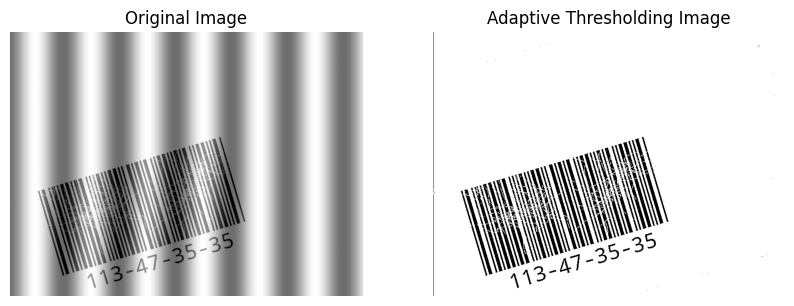

In [322]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image = cv2.imread('Test Cases\\11 - bayza 5ales di bsara7a.jpg')

# Step 2: Convert the image to grayscale if it's not already
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Apply adaptive thresholding
# You can experiment with the block size and C value to fine-tune the result
adaptive_thresh_image = cv2.adaptiveThreshold(
    gray_image, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # or cv2.ADAPTIVE_THRESH_MEAN_C
    cv2.THRESH_BINARY, 
    11,  # block size (must be an odd number)
    2    # constant subtracted from the mean or weighted mean
)

# Save the processed image
cv2.imwrite('adaptive_threshold_image.jpg', adaptive_thresh_image)

# Step 4: Display the original and processed images
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for correct color display
plt.axis('off')

# Show the processed image
plt.subplot(1, 2, 2)
plt.title("Adaptive Thresholding Image")
plt.imshow(adaptive_thresh_image, cmap='gray')
plt.axis('off')

plt.show()
